In [2]:

import pandas as pd
import numpy as np
from jeffutils.utils import set_np_pd_display_params, print_display, movecol
import os
import matplotlib.pyplot as plt
from itertools import product
from sklearn.neighbors import KernelDensity
from collections import defaultdict
from tqdm.auto import tqdm
from random import choice
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import pickle
from scipy.stats import entropy, wasserstein_distance, pearsonr
import json
from copy import deepcopy

from py_files.data_manager import RELEVANT_COLUMNS, EVENTS_IGNORED, load_and_clean_csv
from py_files.helper_funcs import get_data, get_label_encoder

set_np_pd_display_params(np, pd)
# set max rows for pandas dataframe to 100
pd.set_option("display.max_rows", 100)

DATA_PATH = "data/play_by_play/"

In [10]:
game_ids = df_full['game_id'].unique()

In [11]:
random_game_ids = np.random.choice(game_ids, size=50)
print(repr(list(random_game_ids)))

[2012020096, 2013021021, 2017021194, 2015020634, 2011020966, 2010020583, 2017020084, 2016020930, 2015020979, 2019020834, 2023020536, 2016020365, 2013020358, 2021021187, 2019020865, 2013020593, 2017020112, 2012020133, 2010020459, 2019030143, 2013020770, 2016020159, 2017021208, 2014020783, 2018020686, 2013020148, 2014020398, 2021020619, 2015020389, 2018020802, 2019020266, 2016020932, 2016020842, 2010020400, 2010020564, 2014030126, 2010020962, 2013020389, 2010020935, 2022030223, 2015021151, 2018020114, 2022020202, 2013020041, 2013020695, 2010021111, 2012020301, 2014020417, 2019020475, 2013020775]


In [12]:
lst = [2022020839, 2023020412, 2022020727, 2022030154, 2022021296, 2023020164, 2022020793, 2023020317, 2022020971, 2022030145, 2022020938, 2022021300, 2022021101, 2022020747, 2023020254, 2022020832, 2022020842, 2022021012, 2023020268, 2022020867, 2022030324, 2023020546, 2022021001, 2022021055, 2023020464, 2022021181, 2023020096, 2022020688, 2023020325, 2022021166, 2022020932, 2022020843, 2023020365, 2022030245, 2022021040, 2022021088, 2023020570, 2023020264, 2023020129, 2022020876, 2023020292, 2023020010, 2022021270, 2022021115, 2022020753, 2023020475, 2023020192, 2022020662, 2023020033, 2023020482]
print(len(lst))
print(len(np.unique(lst)))

50
50


# simulate a game and save probabilities along the way

In [ ]:
from py_files.simulator import get_simulation_prob

In [13]:
df_full = pd.read_feather("data/play_by_play/play_by_play_full_state_space.feather")
display(df_full)

,game_date,date_time,game_id,home_name,away_name,event_type,penalty_severity,penalty_minutes,event_team,event_team_type,period_type,period,period_seconds,period_seconds_remaining,game_seconds,game_seconds_remaining,home_score,away_score,home_final,away_final,strength_state,strength_code,strength,empty_net,extra_attacker,home_skaters,away_skaters,order,STATE_BLOCKED_SHOT_AWAY,STATE_BLOCKED_SHOT_HOME,STATE_FACEOFF_AWAY,STATE_FACEOFF_HOME,STATE_GIVEAWAY_AWAY,STATE_GIVEAWAY_HOME,STATE_GOAL_AWAY,STATE_GOAL_HOME,STATE_MISSED_SHOT_AWAY,STATE_MISSED_SHOT_HOME,STATE_PENALTY_AWAY,STATE_PENALTY_HOME,STATE_SHOT_AWAY,STATE_SHOT_HOME,STATE_TAKEAWAY_AWAY,STATE_TAKEAWAY_HOME
0,2010-10-07,2010-10-07T23:29:40Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,FACEOFF_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,0,1200.0000000,0,3600,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010-10-07,2010-10-07T23:30:52Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,GIVEAWAY_HOME,-,0.0000000,Toronto Maple Leafs,home,REGULAR,1,69,1131.0000000,69,3531,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2010-10-07,2010-10-07T23:30:56Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,BLOCKED_SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,73,1127.0000000,73,3527,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2010-10-07,2010-10-07T23:31:09Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,86,1114.0000000,86,3514,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,3,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2010-10-07,2010-10-07T23:31:14Z,2010020001,Toronto Maple Leafs,Montréal Canadiens,SHOT_AWAY,-,0.0000000,Montréal Canadiens,away,REGULAR,1,91,1109.0000000,91,3509,0,0,3.0000000,2.0000000,5v5,EV,Even,-,False,5,5,4,1,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3712181,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,BLOCKED_SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1155,45.0000000,3555,45,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712181,15,22,17,31,5,10,2,1,10,21,1,1,22,19,1,6
3712182,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1185,15.0000000,3585,15,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712182,15,22,17,31,5,10,2,1,10,21,1,1,22,20,1,6
3712183,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,SHOT_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1186,14.0000000,3586,14,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712183,15,22,17,31,5,10,2,1,10,21,1,1,22,21,1,6
3712184,2024-03-16,2024-03-16,2023021072,Vancouver Canucks,Washington Capitals,FACEOFF_HOME,-,0.0000000,Vancouver Canucks,home,REGULAR,3,1187,13.0000000,3587,13,1,2,1.0000000,2.0000000,6v5,PP,Power Play,False,True,6,5,3712184,15,22,17,32,5,10,2,1,10,21,1,1,22,21,1,6


In [ ]:
# load the probability table
prob_mc = pd.read_csv("data/probability_tables/probabilities_avg_NOHIT.csv")
prob_mc = prob_mc[['prev3', 'prev2', 'prev1', 'curr_event', 'probability_avg']]
prob_mc = prob_mc.rename(columns={'probability_avg': 'probability'})

In [ ]:
norm_prob_mc = prob_mc.copy()
prob_sums = norm_prob_mc.groupby(['prev3', 'prev2', 'prev1'])['probability'].sum()
norm_prob_mc = pd.merge(norm_prob_mc, prob_sums, on=['prev3', 'prev2', 'prev1'], suffixes=('', '_sum'))
norm_prob_mc['probability'] = norm_prob_mc['probability'] / norm_prob_mc['probability_sum']

In [ ]:
df = df_full.copy()

random.seed(42)
game_id = choice(df['game_id'].unique())

curr_game = df.loc[df['game_id'] == game_id, :].copy()
home_name = curr_game['home_name'].values[0]
away_name = curr_game['away_name'].values[0]
game_date = curr_game['game_date'].values[0]

simulation_cols = ['game_seconds_remaining'] + [c for c in curr_game.columns if 'STATE' in c]
simulation_cols_new = [c.replace("STATE_", "") for c in simulation_cols]
state_portion = (curr_game
    .loc[:, simulation_cols]
    .copy()
    .reset_index(drop=True)
    .rename(columns=dict(zip(simulation_cols, simulation_cols_new))))

# load the probability table
prob_mc = pd.read_csv("data/probability_tables/probabilities_avg_NOHIT.csv")
prob_mc = prob_mc[['prev3', 'prev2', 'prev1', 'curr_event', 'probability_avg']]
prob_mc = prob_mc.rename(columns={'probability_avg': 'probability'})

with open("data/pickles/kde_seconds_NOHIT.pickle", "rb") as f:
    kde_seconds = pickle.load(f)
    
# sample from the game every minute
rows_to_simulate = list(range(0, len(state_portion), len(state_portion) // 10))
simulation_probabilities = []
for ind in rows_to_simulate:
    inds = np.arange(max(0, ind-4), ind+1)
    curr_snapshot = state_portion.loc[inds, :].copy()
    print("Seconds remaining:", curr_snapshot['game_seconds_remaining'].values[-1], " "*30, end="\r")
    
    home_prob, away_prob = get_simulation_prob(curr_snapshot, prob_mc, kde_seconds, verbose=True)
    simulation_probabilities.append((home_prob, away_prob))
    

In [ ]:
print(simulation_probabilities)

In [ ]:
display(curr_game)

In [ ]:
thing = curr_game.copy()
thing['STATE_GOAL_HOME_diff'] = thing['STATE_GOAL_HOME'].diff().fillna(0)
goals_rows = thing['STATE_GOAL_HOME_diff'] != 0
home_goals = thing.loc[goals_rows, 'game_seconds'].values

thing['STATE_GOAL_AWAY_diff'] = thing['STATE_GOAL_AWAY'].diff().fillna(0)
goals_rows = thing['STATE_GOAL_AWAY_diff'] != 0
away_goals = thing.loc[goals_rows, 'game_seconds'].values

inds = thing.loc[goals_rows, :].index
inds = np.concatenate([inds-1, inds, inds+1])
inds = np.unique(inds)
inds = np.sort(inds)
thing = movecol(thing, ['STATE_GOAL_HOME_diff'], 'STATE_GOAL_HOME', 'After')
display(thing.loc[inds, ['STATE_GOAL_HOME', 'STATE_GOAL_HOME_diff']])

In [ ]:
# Read in team colors
with open('team_colors.json') as f:
    team_colors = json.load(f)

# Get the game data
game_data = curr_game.copy()
team, opp = game_data['home_name'].values[0], game_data['away_name'].values[0]

# Get who the home team is
home_team = team
away_team = opp

# Get colors for home and away team
home_color = team_colors[home_team]
away_color = team_colors[away_team]

# Predict the win probability
y_pred = deepcopy(simulation_probabilities)

time_vals = curr_game['game_seconds'].values[rows_to_simulate]
pred_vals = np.array([p[0] for p in y_pred])


In [ ]:
# Set threshold
threshold = 0.5

# Plot the probabilities
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(time_vals, pred_vals, color='black')

home_where = pred_vals >= threshold if home_team == team else pred_vals < threshold
away_where = pred_vals < threshold if home_team == team else pred_vals >= threshold

# Fill area above 50% with blue for Home Team
plt.fill_between(time_vals, threshold, pred_vals, where=pred_vals >= threshold, color=home_color['main'], interpolate=True, alpha=0.5)

# Fill area below 50% with red for Home Team
plt.fill_between(time_vals, threshold, pred_vals, where=pred_vals < threshold, color=away_color['main'], interpolate=True, alpha=0.5)

# Add a dotted horizontal line at y = 0.5
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.yticks(ticks=[0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], labels=['100%', '90%', '80%', '70%', '60%', '50%', '60%', '70%', '80%', '90%', '100%'])

# Plot when the goal was scored
plt.vlines(home_goals, 0, 1, color='green', linestyle='--', label=f'{home_team} Goal')
plt.vlines(away_goals, 0, 1, color='purple', linestyle='--', label=f'{away_team} Goal')

# Plot periods
# plt.vlines([1200, 2400, 3600], 0, 1, color='black', linestyle='-', label='Period End')
plt.xticks(ticks=[0, 1200, 2400, 3600], labels=['Game Start', 'End 1st', 'End 2nd', 'End 3rd'])
plt.title(f'{away_team} ({len(away_goals)}) @ {home_team} ({len(home_goals)})')
plt.legend()


# Show plot
plt.show()

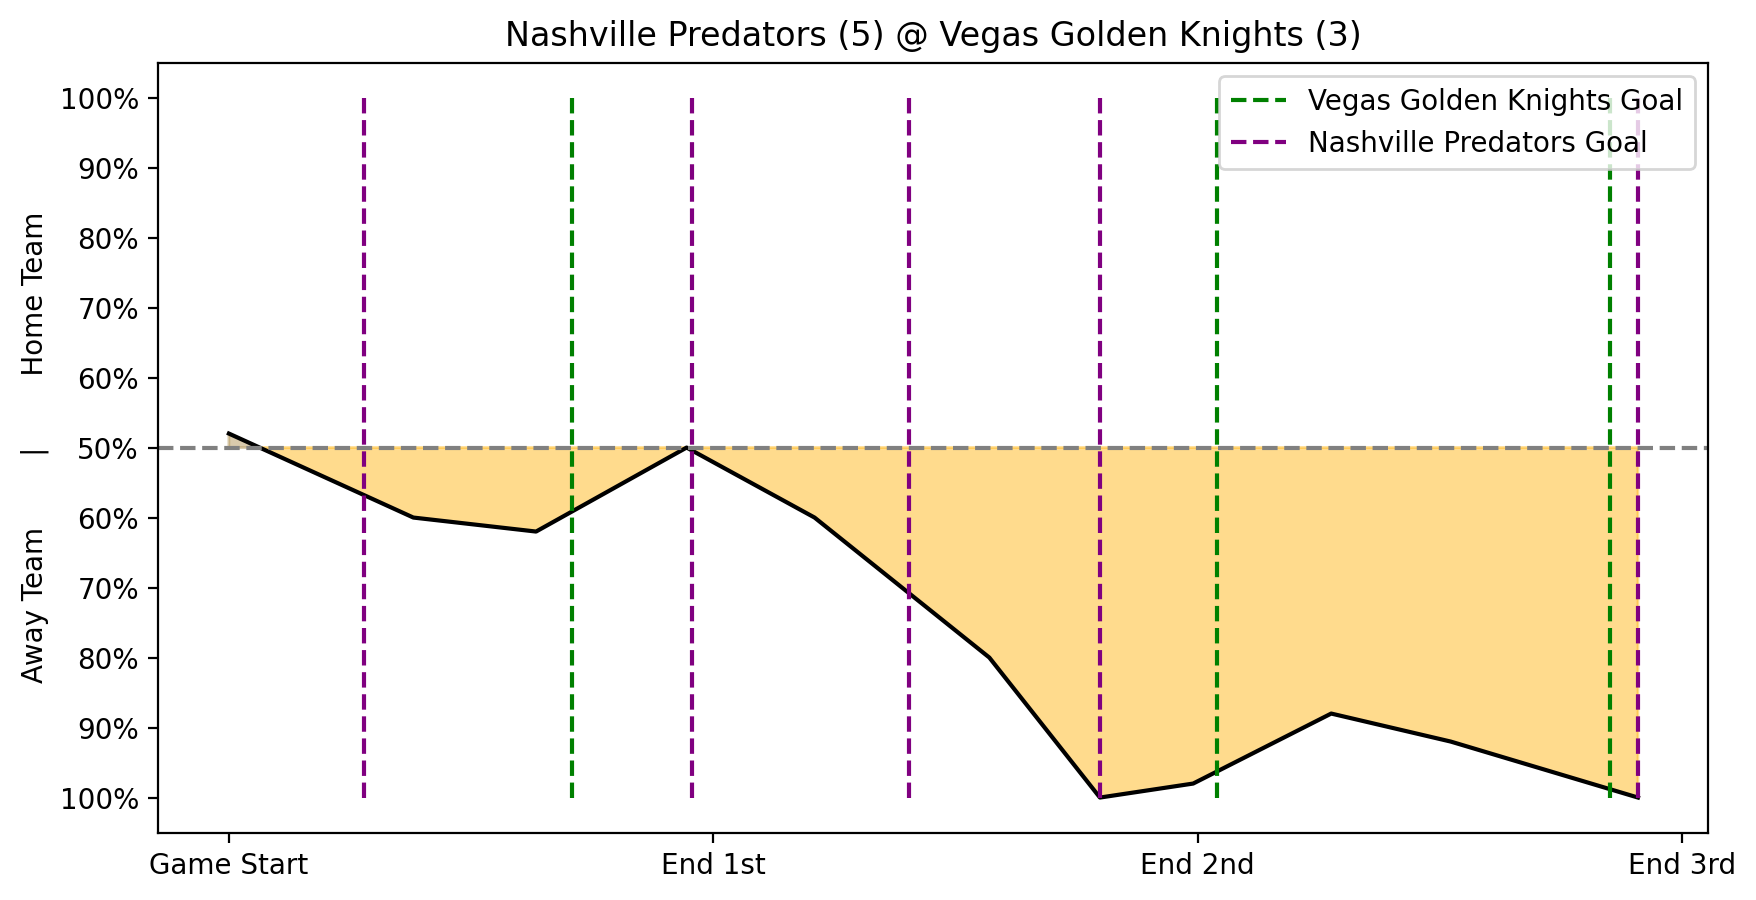

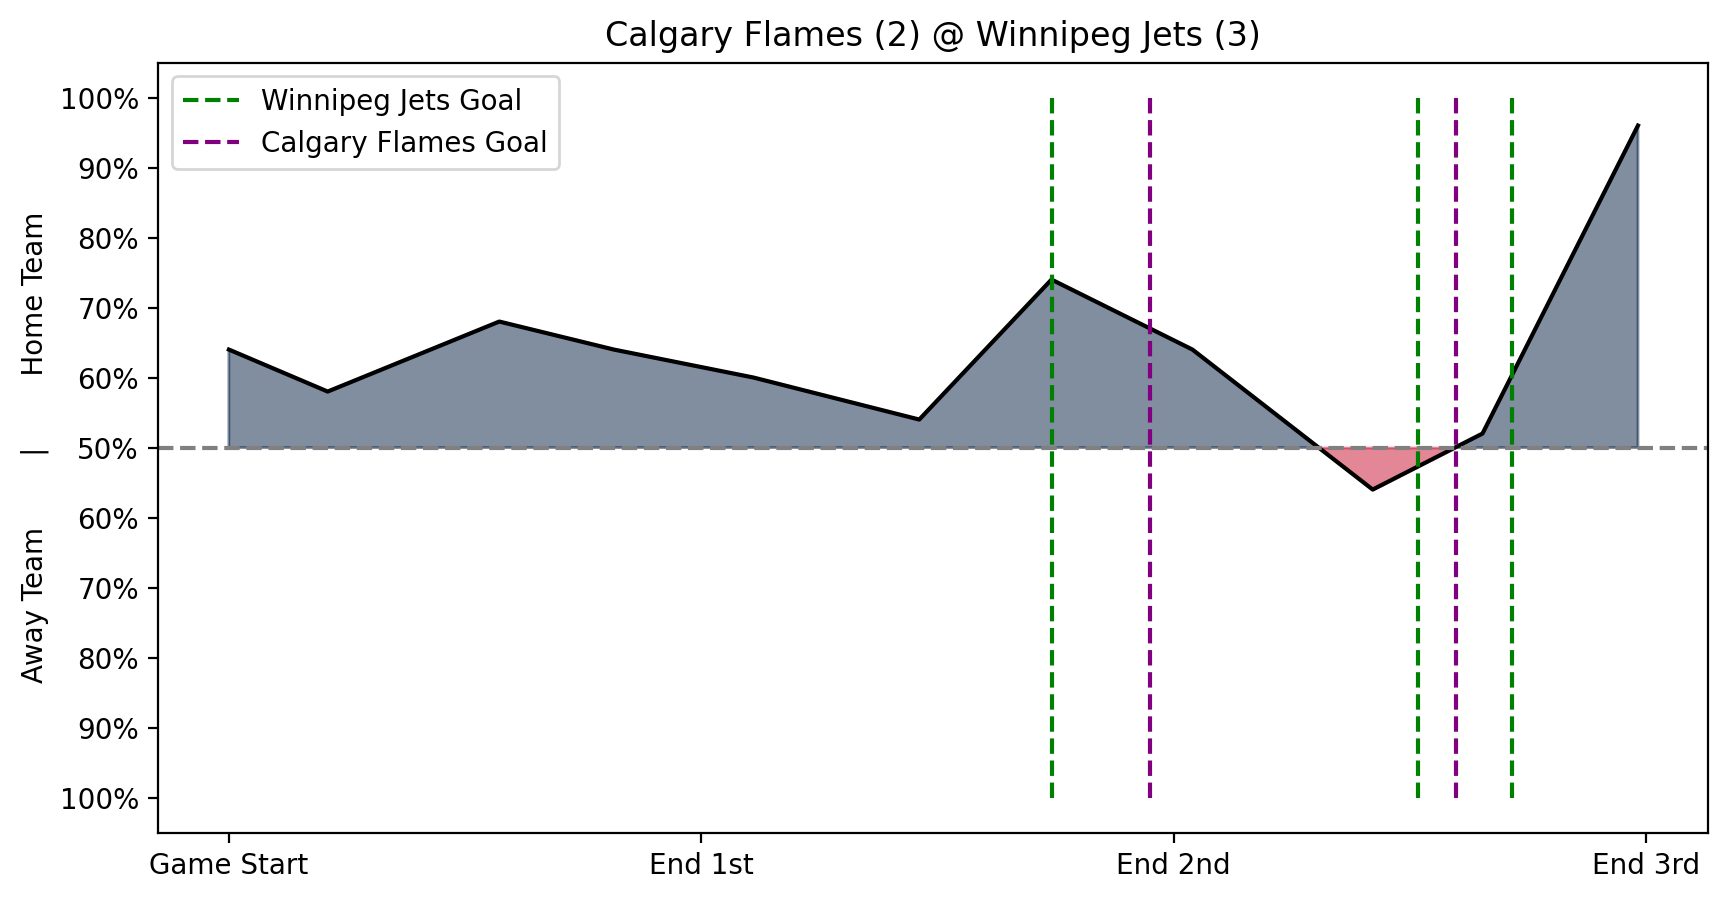

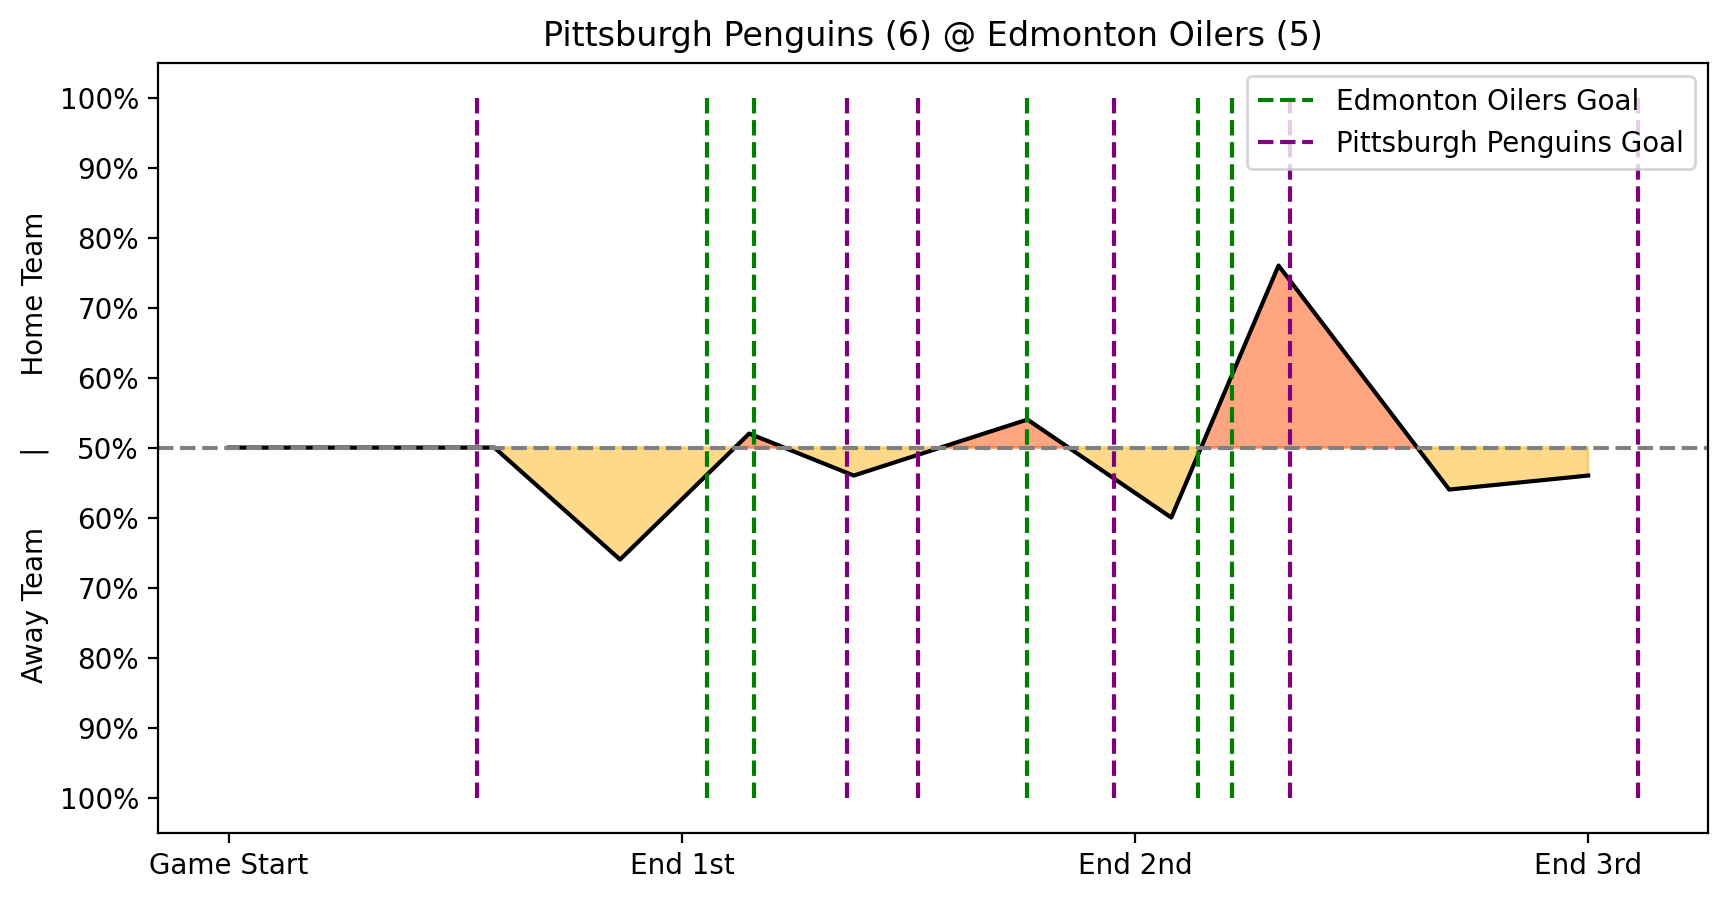

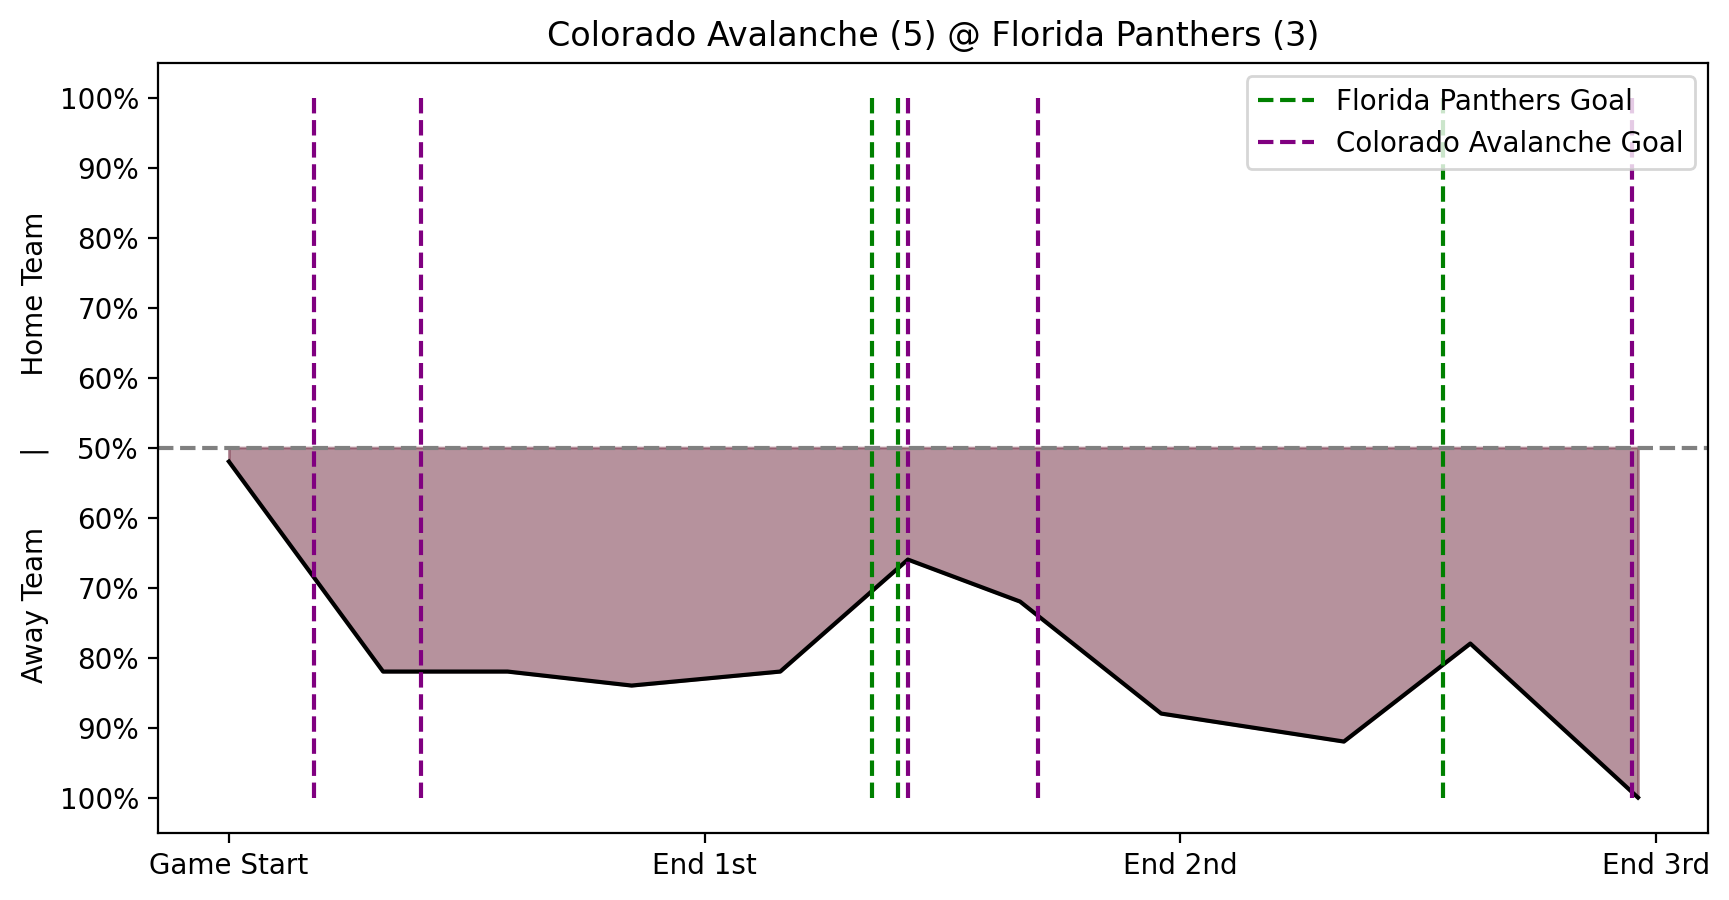

In [8]:
def display_and_save_chart(game_id):
    
    path = f"data/pickles/simulation_probs_{game_id}.pickle"
    if not os.path.exists(path):
        raise ValueError(f"{game_id} does not have simulated results in data/pickles")
    
    with open(path, 'rb') as file:
        simulation_res = pickle.load(file)
    game_id = simulation_res['game_id']
    curr_game = simulation_res['curr_game']
    rows_to_simulate = simulation_res['rows_to_simulate']
    simulation_probabilities = simulation_res['simulation_probabilities']
    
    # get the times of the home and away goals
    thing = curr_game.copy()
    thing['STATE_GOAL_HOME_diff'] = thing['STATE_GOAL_HOME'].diff().fillna(0)
    goals_rows = thing['STATE_GOAL_HOME_diff'] != 0
    home_goals = thing.loc[goals_rows, 'game_seconds'].values

    thing['STATE_GOAL_AWAY_diff'] = thing['STATE_GOAL_AWAY'].diff().fillna(0)
    goals_rows = thing['STATE_GOAL_AWAY_diff'] != 0
    away_goals = thing.loc[goals_rows, 'game_seconds'].values
    
    # Read in team colors
    with open('team_colors.json') as f:
        team_colors = json.load(f)

    # Get the game data
    game_data = curr_game.copy()
    team, opp = game_data['home_name'].values[0], game_data['away_name'].values[0]

    # Get who the home team is
    home_team = team
    away_team = opp

    # Get colors for home and away team
    home_color = team_colors[home_team]
    away_color = team_colors[away_team]

    # Predict the win probability
    y_pred = deepcopy(simulation_probabilities)

    time_vals = curr_game['game_seconds'].values[rows_to_simulate]
    pred_vals = np.array([p[0] for p in y_pred])
    
    # Set threshold
    threshold = 0.5

    # Plot the probabilities
    plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(time_vals, pred_vals, color='black')

    home_where = pred_vals >= threshold if home_team == team else pred_vals < threshold
    away_where = pred_vals < threshold if home_team == team else pred_vals >= threshold

    # Fill area above 50% with blue for Home Team
    plt.fill_between(time_vals, threshold, pred_vals, where=pred_vals >= threshold, color=home_color['main'], interpolate=True, alpha=0.5)

    # Fill area below 50% with red for Home Team
    plt.fill_between(time_vals, threshold, pred_vals, where=pred_vals < threshold, color=away_color['main'], interpolate=True, alpha=0.5)

    # Add a dotted horizontal line at y = 0.5
    plt.axhline(y=0.5, color='gray', linestyle='--')
    plt.yticks(ticks=[0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], labels=['100%', '90%', '80%', '70%', '60%', '50%', '60%', '70%', '80%', '90%', '100%'])

    # Plot when the goal was scored
    plt.vlines(home_goals, 0, 1, color='green', linestyle='--', label=f'{home_team} Goal')
    plt.vlines(away_goals, 0, 1, color='purple', linestyle='--', label=f'{away_team} Goal')

    # Plot periods
    # plt.vlines([1200, 2400, 3600], 0, 1, color='black', linestyle='-', label='Period End')
    plt.xticks(ticks=[0, 1200, 2400, 3600], labels=['Game Start', 'End 1st', 'End 2nd', 'End 3rd'])
    plt.title(f'{away_team} ({len(away_goals)}) @ {home_team} ({len(home_goals)})')
    plt.ylabel("Away Team        |        Home Team")
    plt.legend()
    
    a, ag, h, hg = away_team, len(away_goals), home_team, len(home_goals)
    plt.savefig(f"Latex/images/mcmc_{a}_{ag}_{h}_{hg}_{game_id}.pdf", dpi=300, bbox_inches="tight")
    plt.savefig(f"Latex/images/mcmc_{a}_{ag}_{h}_{hg}_{game_id}.png", dpi=300, bbox_inches="tight")
    
    # Show plot
    plt.show()
    
# loop over every file name in data/pickles
directory = "data/pickles"
for file_name in os.listdir(directory):
    path = os.path.join(directory, file_name)
    if os.path.exists(path) and "simulation_probs" in file_name:
        game_id = int(file_name.split("_")[-1].split(".")[0])
        display_and_save_chart(game_id)
    

# check kde ~ poisson(18)

In [ ]:
with open("data/pickles/kde_seconds_NOHIT.pickle", "rb") as f:
    kde_seconds = pickle.load(f)
    
sample = kde_seconds.sample(100000)

poisson_sample = np.random.poisson(18, 100000)

plt.hist(sample, bins=100, alpha=0.5, label="kde", density=True)
plt.hist(poisson_sample, bins=100, alpha=0.5, label="poisson", density=True)
plt.legend()
plt.show()

# code for the writeup

In [ ]:
probs = pd.read_csv("data/probability_tables/probabilities_avg_NOHIT.csv")
display(probs)

In [ ]:
print(probs['curr_event'].unique())

In [ ]:
with open("data/pickles/kde_seconds_NOHIT.pickle", "rb") as f:
    kde_seconds = pickle.load(f)
    
sample = kde_seconds.sample(10000000)
print(np.mean(sample))

In [ ]:
prev_events = "SHOT_AWAY,BLOCKED_SHOT_HOME,TAKEAWAY_HOME"
prev3 = "FACEOFF_HOME"
prev2 = "GIVEAWAY_HOME"
prev1 = "MISSED_SHOT_AWAY"
curr_probs = (probs
    .loc[
        (probs['prev3'] == prev3) & 
        (probs['prev2'] == prev2) & 
        (probs['prev1'] == prev1) &
        (probs['curr_event'] != 'BLOCKED_SHOT_-'), 
        ['prev3', 'prev2', 'prev1', 'curr_event', 'probability_avg']]
    .copy()
    .sort_values(by='probability_avg', ascending=False)
    .rename(columns={'probability_avg': 'probability', 'curr_event':'next_event'})
)
#curr_probs = curr_probs.loc[(curr_probs['next_event'] != 'BLOCKED_SHOT_-'), :]
curr_probs['curr_state'] = curr_probs['prev3'].astype(str) + "," + curr_probs['prev2'].astype(str) + "," + curr_probs['prev1'].astype(str)
curr_probs = curr_probs[['curr_state', 'next_event', 'probability']]
display(curr_probs.head(4))
print_display('curr_probs', globals(), 4)

In [ ]:
df['away_strength_code'] = 'EV'
df.loc[df['strength_code'] == 'PP', 'away_strength_code'] = 'SH'
df.loc[df['strength_code'] == 'SH', 'away_strength_code'] = 'PP'

# load full state_space

In [ ]:
from py_files.data_manager import create_state_space_opt
df = create_state_space_opt('data/play_by_play/play_by_play_full.feather', True)
display(df)

In [ ]:
df.reset_index(drop=True).to_feather('data/play_by_play/play_by_play_full_state_space.feather')

# analyze effectiveness of our simulator vs. actual

In [ ]:
# load the full state space feather
df = pd.read_feather('data/play_by_play/play_by_play_full_state_space.feather')

simulation_500 = pd.read_feather('data/simulated_games/nohit_500.feather')
simulation_1000 = pd.read_feather('data/simulated_games/nohit_1000.feather')

simulation_500['game_id'] = (simulation_500['game_id'].astype(int) + 2000).astype(str).str.zfill(5)
# load the simulated games
simulations = pd.concat([simulation_1000, simulation_500])
display(df)
display(simulations)

In [ ]:
# create copies of the dataframes to make this cell re-runnable
simulated = simulations.copy()
actual = df.copy()

# only keep the relvenat state columns
state_cols = [c for c in actual.columns if 'STATE' in c]
rel_cols = ['game_id'] + state_cols
actual = actual[rel_cols]

simulated_state_cols = [c.replace("STATE_", "") for c in state_cols]
actual = actual.rename(columns={c: c.replace("STATE_", "") for c in state_cols})
rel_cols = ['game_id'] + simulated_state_cols
simulated = simulated[rel_cols]

# only keep the last rows
sim_last_rows = simulated['game_id'] != simulated['game_id'].shift(-1)
simulated = simulated.loc[sim_last_rows, :]
actual_last_rows = actual['game_id'] != actual['game_id'].shift(-1)
actual = actual.loc[actual_last_rows, :]

actual = actual.sample(n=1500)

print("Simulated last rows")
display(simulated)
print("actual last rows")
display(actual)

In [ ]:
event_cols = [c for c in actual.columns if c != 'game_id']
print(len(event_cols))

for i, col in enumerate(event_cols):
    plt.subplot(4, 4, i+1)
    actual_vals = actual.sample(n=1500)[col].values
    simulated_vals = simulated[col].values
    
    actual_vals_probs = np.histogram(actual_vals, bins=50, density=True)[0]
    simulated_vals_probs = np.histogram(simulated_vals, bins=50, density=True)[0]
    # compute the KL divergence between actual_vals and simulated_vals
    emd = wasserstein_distance(actual_vals_probs, simulated_vals_probs)
    plt.hist(actual_vals, bins=50, color='green', alpha=0.5, label='Actual', edgecolor='white', density=True)
    plt.hist(simulated_vals, bins=50, color='red', alpha=0.5, label='Simulated', edgecolor='white', density=True)
    plt.legend()
    plt.title(f"{col}, EMD: {emd:.2f}")

plt.gcf().set_size_inches(20, 15)
plt.tight_layout()
plt.show()


In [ ]:
# Assign labels
actual["simulated"] = 0
simulated["simulated"] = 1

# combine the actual and simulated games and shuffle the rows
vals = (
    pd.concat([
           actual.drop(columns='game_id').copy(), # only use 1700 of the actual games
           simulated.drop(columns='game_id').copy()])
    .sample(frac=1.0) # shuffle the rows
    .reset_index(drop=True)
)
X, y = vals.drop(columns=["simulated"]), vals.simulated
X.fillna(0, inplace=True)
X = X.values
y = y.values

In [ ]:
# split X and y into train and test with 70-30
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# run a kmeans with two clusters on X and y
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train, y_train)
y_pred = kmeans.predict(X_test)
print("Accuracy of KMeans:", round(np.sum(y_pred == y_test) / len(y_test), 4))

# run another classifier on X and y and print the accuracy
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy of Logistic Regression:", round(np.sum(y_pred == y_test) / len(y_test), 4))

# run an XGBoost classifier on X and y and print the accuracy
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("Accuracy of XGBoost:", round(np.sum(y_pred == y_test) / len(y_test), 4))

# run a random forest classifier on X and y and print the accuracy
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy of Random Forest:", round(np.sum(y_pred == y_test) / len(y_test), 4))


In [ ]:
# Assign labels
actual["simulated"] = 0
simulated["simulated"] = 1

# combine the actual and simulated games and shuffle the rows
vals = (
    pd.concat([
           actual.copy().sample(frac=0.1), # only use 1700 of the actual games
           simulated.copy()])
    .sample(frac=1.0) # shuffle the rows
    .reset_index(drop=True)
)
X, y = vals.drop(columns=["simulated"]), vals.simulated

# Fill all NaN's with 0
X.fillna(0, inplace=True)

vals = {}

pbar = tqdm(total=9)
# Perform PCA, t-SNE, and UMAP on the data
pbar.set_description("Performing PCA")
X_pca = PCA(n_components=2).fit_transform(X)
pbar.update(1)

vals[(0, 0)] = X_pca

for perp, neigh in [(50, 25), (100, 50), (250, 150), (500, 300)]:
    # Compute t-SNE
    pbar.set_description(f"Performing t-SNE (Perplexity = {perp})")
    X_tsne = TSNE(n_components=2, perplexity=perp).fit_transform(X)
    pbar.update(1)

    # Compute UMAP
    pbar.set_description(f"Performing UMAP (Neighbors = {neigh})")
    X_umap = UMAP(n_components=2, n_neighbors=neigh).fit_transform(X)
    pbar.update(1)
    
    vals[(perp, neigh)] = (X_tsne, X_umap)

In [ ]:
i = 0
for key, value in vals.items():
    if key == (0,0):
        continue
    perp, neigh = key
    X_tsne, X_umap = value
    
    plt.subplot()
    i += 1
    


In [ ]:


# Do t-SNE, UMAP, and PCA on the simulated data against the real data
# Simulated data
simulated = pd.read_feather('data/dylan_data/lasts.feather')
actual = last_row.copy()
actual.drop(columns=['TIME_REMAINING', 'WIN', 'GAME_ID', 'AWAY_CORSI_FOR',
       'AWAY_FENWICK_FOR', 'HOME_CORSI_FOR', 'HOME_FENWICK_FOR', 'AWAY_CORSI', 'AWAY_FENWICK',
       'AWAY_GAME_ID', 'AWAY_TIME_REMAINING', 'AWAY_WIN', 'HOME_CORSI',
       'HOME_FENWICK', 'HOME_GAME_ID', 'HOME_HIT', 'AWAY_HIT',
       'HOME_TEAM', 'HOME_TIME_REMAINING', 'HOME_WIN', 'AWAY_HOME','AWAY_TEAM', 'HOME_HOME',
       ], inplace=True)

simulated.drop(columns=['time_remaining', 'home_score', 'away_score', 'game_id', 'BLOCKED_SHOT_-'], inplace=True)
actual = actual[actual.columns.sort_values()]
simulated = simulated[simulated.columns.sort_values()]
simulated.columns = [f'{col[-1]}_{"_".join(col[:-1])}' for col in simulated.columns.str.split('_')]
simulated = simulated[simulated.columns.sort_values()]

# Assign labels
actual['simulated'] = 0
simulated['simulated'] = 1

vals = actual.append(simulated)
X, y = vals.drop(columns=['simulated']), vals.simulated

# Fill all NaN's with 0
X.fillna(0, inplace=True)

# Perform PCA, t-SNE, and UMAP on the data
X_pca = PCA(n_components=2).fit_transform(X)

fig, ax = plt.subplots(3,3, figsize=(16, 10))
i = 0
for perp, neigh in [[100, 50], [250, 150], [500, 300]]:
       # Compute t-SNE
       X_tsne = TSNE(n_components=2, perplexity=perp).fit_transform(X)
       
       # Compute UMAP
       X_umap = UMAP(n_components=2, n_neighbors=neigh).fit_transform(X)
       
       # Plot the results
       ax[i, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
       ax[i, 0].set_title('PCA')
       
       ax[i, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
       ax[i, 1].set_title(f't-SNE (Perplexity = {perp})')
       
       ax[i, 2].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', alpha=0.7)
       ax[i, 2].set_title(f'UMAP (Neighbors = {neigh}')
       
       i += 1
       

# load ALL of the data and clean it

In [ ]:
dataframes = []
for file in sorted(list(os.listdir(DATA_PATH))):
    if file.endswith(".csv") and 'play_by_play' in file:
        print(file)
        df = load_and_clean_csv(os.path.join(DATA_PATH, file))
        df.reset_index(drop=True).to_feather(os.path.join(DATA_PATH, file.replace(".csv", "_clean.feather")))
        dataframes.append(df)

df_orig = pd.concat(dataframes, ignore_index=True)
df_orig = df_orig.sort_values(by=["date_time", "game_id", "game_seconds"]).reset_index(drop=True)
df_orig.reset_index(drop=True).to_feather(os.path.join(DATA_PATH, "play_by_play_full.feather"))

# load the full play_by_play feather fule

In [ ]:
df_orig = pd.read_feather(os.path.join(DATA_PATH, "play_by_play_full.feather"))
display(df_orig)

# create the net_player feature

In [ ]:
df_net = df_orig.copy()
df_net['home_skaters'] = df_net['home_skaters'].astype(int)
df_net['away_skaters'] = df_net['away_skaters'].astype(int)

# forward fill the home_skaters zero values
df_net['home_skaters'] = df_net['home_skaters'].replace(0, np.nan).ffill().astype(int)
df_net['away_skaters'] = df_net['away_skaters'].replace(0, np.nan).ffill().astype(int)

# compute a new strength_state column that is always in perspective of home
df_net['strength_state'] = df_net['home_skaters'].copy().astype(str) + 'v' + df_net['away_skaters'].copy().astype(str)

# create the net_players column that keeps track of when home or away are in a power play or short handed
df_net['net_players'] = 'EV'
df_net.loc[df_net['home_skaters'] > df_net['away_skaters'], 'net_players'] = 'PP'
df_net.loc[df_net['home_skaters'] < df_net['away_skaters'], 'net_players'] = 'SH'
display(df_net['net_players'].value_counts())

# setup df_events

In [ ]:
#df = df_net.copy()
df = pd.read_feather('data/play_by_play/play_by_play_full_state_space.feather')

# consolidate the overall dataframe into a dataframe with just events and the net_players entry
#df_events = df[['game_id', 'event_type', 'game_seconds', 'event_team_type', 'net_players']].copy()
df_events = df[['game_id', 'event_type', 'game_seconds', 'event_team_type']].copy()

# ignore the HIT events
df_events = df_events.loc[~(df_events['event_type'] == 'HIT'), :].copy()

'''df_events['event'] = (
    df_events['event_type'].astype(str) 
    +'_' + df_events['event_team_type'].astype(str).str.upper()  
    #+ "_" + df_events['net_players'].astype(str)
)'''
df_events['event'] = df_events['event_type'].astype(str)
df_events = df_events.sort_values(by=['game_id', 'game_seconds'], ascending=[True, True])
df_events = df_events[['game_id', 'event', 'game_seconds']]

first_rows = df_events['game_id'] != df_events['game_id'].shift(1)
df_events['seconds_diff'] = np.abs(df_events['game_seconds'].diff().fillna(0))
df_events.loc[first_rows, 'seconds_diff'] = 0
df_events = df_events.reset_index(drop=True)

# compute the probability tables for the MC

In [ ]:
def normalize_probabilities(probabilities:pd.DataFrame, probability_col_name:str):
    """ takes in a dataframe with columns 'prev_events' and probability_col_name
    and normalizes the probability_col_name column for all probabilities in each
    prev_events group
    """
    col_name_sum = probability_col_name + '_sum'
    
    probs_sums = (probabilities
        .copy()
        .groupby(by=['prev_events'])[probability_col_name]
        .sum()
        .reset_index()
        .rename(columns={probability_col_name: col_name_sum}))
    
    probabilities = pd.merge(probabilities, probs_sums, on=['prev_events'], how='left')
    probabilities[probability_col_name] /= probabilities[col_name_sum]
    probabilities = probabilities.drop(columns=[col_name_sum])
    probabilities = probabilities.fillna(0)
    
    return probabilities

def compute_probabilities(df, prev_count=3):
    """ takes in a dataframe with the columns "game_id", "event_type", "game_seconds", and "event_team_type"
    and an integer prev_count that represents the number of previous events to consider.
    Returns a dataframe with the columns "prev_events", "curr_event", "probability", "given_count", "join_count"
    where prev_events will have 'prev_count' event names separated by commas
    
    probabilities df
    prev_events	                     curr_event	    probability	given_count	join_count
    BLOCKED_SHOT_AWAY,GOAL_AWAY,BLOCKED_SHOT_AWAY	FACEOFF_HOME	0.86	86	100
    MISSED_SHOT_HOME,PENALTY_HOME,BLOCKED_SHOT_HOME	FACEOFF_AWAY	0.84	84	100
    """
    df_cols = ['game_id', 'event_type', 'game_seconds', 'event_team_type']
    if not all([col in df.columns for col in df_cols]):
        raise ValueError(f"Dataframe must have the columns {df_cols}")
    df = df.copy()
    
    ############################################################
    #                     CREATE DF_EVENTS                     #
    ############################################################

    # consolidate the overall dataframe into a dataframe with just events and the net_players entry
    #df_events = df[['game_id', 'event_type', 'game_seconds', 'event_team_type', 'net_players']].copy()
    df_events = df[['game_id', 'event_type', 'game_seconds', 'event_team_type']].copy()

    # ignore the HIT events
    df_events = df_events.loc[~(df_events['event_type'] == 'HIT'), :].copy()

    df_events['event'] = (
        df_events['event_type'].astype(str) 
        +'_' + df_events['event_team_type'].astype(str).str.upper()  
        #+ "_" + df_events['net_players'].astype(str)
    )
    
    replaces = [('_HOME_HOME', '_HOME'), ('_AWAY_AWAY', '_AWAY')]
    for orig, new in replaces:
        df_events['event'] = df_events['event'].str.replace(orig, new)
    
    df_events = df_events.sort_values(by=['game_id', 'game_seconds'], ascending=[True, True])
    df_events = df_events[['game_id', 'event', 'game_seconds']]

    first_rows = df_events['game_id'] != df_events['game_id'].shift(1)
    df_events['seconds_diff'] = np.abs(df_events['game_seconds'].diff().fillna(0))
    df_events.loc[first_rows, 'seconds_diff'] = 0
    df_events = df_events.reset_index(drop=True)
    
    ############################################################
    #               CREATE THE MARKOV CHAIN TABLE              #
    ############################################################
    
    prev_cols = [f'prev{i}' for i in range(1, prev_count+1)]

    # only keep the event and the game_id
    df_mc = df_events[['game_id', 'event']].copy()
    
    row_masks = []
    for prev_i in range(1, prev_count+1):
        
        # find the current ith rows for each game_id
        curr_rows = df_mc['game_id'] != df_mc['game_id'].shift(prev_i)
        
        # create the current mask and the join mask
        curr_mask = curr_rows.copy()
        join_mask = curr_mask.copy()
        for row_mask in row_masks:
            curr_mask &= (~row_mask)
            join_mask |= row_mask
            
        # add the prev<i> column and make sure that the shift doesn't carry over to the next game
        df_mc[f'prev{prev_i}'] = df_mc['event'].shift(prev_i)
        df_mc.loc[join_mask, f'prev{prev_i}'] = "#"
        
        row_masks.append(curr_mask)
        
    # create the prev_events column as a series with empty strings
    curr_prev_events = pd.Series(["" for _ in range(df_mc.shape[0])], index=df_mc.index.copy())
    
    for prev_i in range(prev_count, 0, -1):
        if prev_i != 1:
            curr_prev_events += df_mc[f'prev{prev_i}'].astype(str) + ","
        else:
            curr_prev_events += df_mc[f'prev{prev_i}'].astype(str)
    df_mc['prev_events'] = curr_prev_events
            
    df_mc = df_mc.dropna()
    df_mc['curr_event'] = df_mc['event']
    
    with open(f"data/pickles/temp_{prev_count}.pickle", "wb") as f:
        pickle.dump(df_mc, f)
    
    ############################################################
    #  COMPUTE THE PROBABILITIES AS P(B|A) = P(A AND B) / P(A) #
    ############################################################
    
    # create a probabilities dataframe that continas the probability of moving from
    # prev3-prev2-prev1 -> curr_event
    prev_events = df_mc['prev_events'].unique()
    curr_events = df_mc['curr_event'].unique()

    probabilities = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
    probabilities['join'] = probabilities['prev_events'] + '|' + probabilities['curr_event']

    # compute the given-this counts
    given_counts = df_mc['prev_events'].value_counts()
    given_counts = pd.DataFrame(given_counts).reset_index()
    given_counts.columns = ['prev_events', 'given_count']

    # compute the joint counts
    df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
    join_counts = df_mc['join'].value_counts()
    join_counts = pd.DataFrame(join_counts).reset_index()
    join_counts.columns = ['join', 'join_count']

    # join the counts onto the probabilities dataframe
    probabilities = probabilities.merge(given_counts, on='prev_events', how='left')
    probabilities = probabilities.merge(join_counts, on='join', how='left')
    probabilities = probabilities.fillna(0)
    probabilities['probability'] = probabilities['join_count'] / probabilities['given_count']
    probabilities = probabilities.sort_values(by='probability', ascending=False)
    probabilities = probabilities[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
    
    # add back in the prev<i> columns
    probabilities = pd.merge(probabilities, df_mc[['prev_events'] + prev_cols].drop_duplicates(), on='prev_events', how='left')
    probabilities = movecol(probabilities, prev_cols[::-1], 'prev_events', 'Before')
    
    # normalize the probabilities so each prev_events group sums to 1
    probabilities = normalize_probabilities(probabilities, 'probability')
    
    return probabilities

def get_probability_table(save_path="data/probability_tables/probabilities_avg_NOHIT.csv"):

    # compute all of the individual probability tables
    df = pd.read_feather('data/play_by_play/play_by_play_full_state_space.feather')
    probabilities1 = compute_probabilities(df, 1)
    probabilities2 = compute_probabilities(df, 2)
    probabilities3 = compute_probabilities(df, 3)
    
    curr_events = probabilities1['curr_event'].unique()

    # create a probabilities dataframe with all of the possible 3-state + curr combinations
    start_states = [('#', '#', '#')]
    start_states += list(product(['#'], ['#'], curr_events))
    start_states += list(product(['#'], curr_events, curr_events))
    start_states += list(product(curr_events, curr_events, curr_events))

    all_states = list(product(start_states, curr_events))
    all_states = [a + (b, ) for a, b in all_states]

    probabilities_avg = pd.DataFrame(all_states, columns=['prev3', 'prev2', 'prev1', 'curr_event'])
    probabilities_avg['3event'] = probabilities_avg['prev3'] + ',' + probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
    probabilities_avg['2event'] = probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
    probabilities_avg['1event'] = probabilities_avg['prev1']

    probabilities_avg['3event_join'] = probabilities_avg['3event'] + '|' + probabilities_avg['curr_event']
    probabilities_avg['2event_join'] = probabilities_avg['2event'] + '|' + probabilities_avg['curr_event']
    probabilities_avg['1event_join'] = probabilities_avg['1event'] + '|' + probabilities_avg['curr_event']

    probabilities1['1event_join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']
    probabilities2['2event_join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']
    probabilities3['3event_join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

    probabilities_avg = probabilities_avg.merge(probabilities1[['1event_join', 'probability', 'given_count', 'join_count']], on='1event_join', how='left', suffixes=('', '_1'))
    probabilities_avg = probabilities_avg.merge(probabilities2[['2event_join', 'probability', 'given_count', 'join_count']], on='2event_join', how='left', suffixes=('', '_2'))
    probabilities_avg = probabilities_avg.merge(probabilities3[['3event_join', 'probability', 'given_count', 'join_count']], on='3event_join', how='left', suffixes=('', '_3'))
    probabilities_avg = probabilities_avg.fillna(0)
    probabilities_avg = probabilities_avg.rename(columns={'given_count': 'given_count_1', 'join_count': 'join_count_1', 'probability': 'probability_1'})

    probabilities_avg['probability_avg'] = (probabilities_avg['probability_1'] + probabilities_avg['probability_2'] + probabilities_avg['probability_3']) / 3
    rel_cols = [
        'prev3', 'prev2', 'prev1', 'curr_event', 'probability_avg',
        'probability_1', 'probability_2', 'probability_3',
        'given_count_1', 'given_count_2', 'given_count_3',
        'join_count_1',  'join_count_2', 'join_count_3']
    probabilities_avg = probabilities_avg[rel_cols]

    # normalize the probabilities_avg
    prob_avg_sum = probabilities_avg.groupby(['prev3', 'prev2', 'prev1'])['probability_avg'].sum().reset_index()
    probabilities_avg = pd.merge(probabilities_avg, prob_avg_sum, on=['prev3', 'prev2', 'prev1'], suffixes=('', '_sum'))
    probabilities_avg['probability_avg'] = probabilities_avg['probability_avg'] / probabilities_avg['probability_avg_sum']
    probabilities_avg = probabilities_avg.drop(columns=['probability_avg_sum'])
    
    probabilities_avg.reset_index(drop=True).to_csv(save_path, index=False)
    
    return probabilities_avg

probabilities_avg = get_probability_table()
    

In [ ]:
thing = probabilities_avg.groupby(['prev3', 'prev2', 'prev1'])['probability_avg'].sum().reset_index()
bad_probs = np.abs(thing['probability_avg'].values - 1) > 1e-1

display(thing.loc[bad_probs, :])

In [ ]:
curr_events = probabilities1['curr_event'].unique()

# create a probabilities dataframe with all of the possible 3-state + curr combinations
start_states = [('#', '#', '#')]
start_states += list(product(['#'], ['#'], curr_events))
start_states += list(product(['#'], curr_events, curr_events))
start_states += list(product(curr_events, curr_events, curr_events))

all_states = list(product(start_states, curr_events))
all_states = [a + (b, ) for a, b in all_states]

probabilities_avg = pd.DataFrame(all_states, columns=['prev3', 'prev2', 'prev1', 'curr_event'])
probabilities_avg['3event'] = probabilities_avg['prev3'] + ',' + probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['2event'] = probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['1event'] = probabilities_avg['prev1']

probabilities_avg['3event_join'] = probabilities_avg['3event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['2event_join'] = probabilities_avg['2event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['1event_join'] = probabilities_avg['1event'] + '|' + probabilities_avg['curr_event']

probabilities1['1event_join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']
probabilities2['2event_join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']
probabilities3['3event_join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

probabilities_avg = probabilities_avg.merge(probabilities1[['1event_join', 'probability', 'given_count', 'join_count']], on='1event_join', how='left', suffixes=('', '_1'))
probabilities_avg = probabilities_avg.merge(probabilities2[['2event_join', 'probability', 'given_count', 'join_count']], on='2event_join', how='left', suffixes=('', '_2'))
probabilities_avg = probabilities_avg.merge(probabilities3[['3event_join', 'probability', 'given_count', 'join_count']], on='3event_join', how='left', suffixes=('', '_3'))
probabilities_avg = probabilities_avg.fillna(0)
probabilities_avg = probabilities_avg.rename(columns={'given_count': 'given_count_1', 'join_count': 'join_count_1', 'probability': 'probability_1'})

probabilities_avg['probability_avg'] = (probabilities_avg['probability_1'] + probabilities_avg['probability_2'] + probabilities_avg['probability_3']) / 3
rel_cols = [
    'prev3', 'prev2', 'prev1', 'curr_event', 'probability_avg',
    'probability_1', 'probability_2', 'probability_3',
    'given_count_1', 'given_count_2', 'given_count_3',
    'join_count_1',  'join_count_2', 'join_count_3']
probabilities_avg = probabilities_avg[rel_cols]

# normalize the probabilities_avg
prob_avg_sum = probabilities_avg.groupby(['prev3', 'prev2', 'prev1'])['probability_avg'].sum().reset_index()
probabilities_avg = pd.merge(probabilities_avg, prob_avg_sum, on=['prev3', 'prev2', 'prev1'], suffixes=('', '_sum'))
probabilities_avg['probability_avg'] = probabilities_avg['probability_avg'] / probabilities_avg['probability_avg_sum']
probabilities_avg = probabilities_avg.drop(columns=['probability_avg_sum'])

display(probabilities_avg)


In [ ]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)
second_rows = (df_mc['game_id'] != df_mc['game_id'].shift(2)) & (~first_rows)
third_rows = (df_mc['game_id'] != df_mc['game_id'].shift(3)) & (~first_rows) & (~second_rows)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc['prev2'] = df_mc['event'].shift(2)
df_mc['prev3'] = df_mc['event'].shift(3)
df_mc.loc[first_rows, 'prev1'] = "#"
df_mc.loc[first_rows | second_rows, 'prev2'] = "#"
df_mc.loc[first_rows | second_rows | third_rows, 'prev3'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev3'] + ',' + df_mc['prev2'] + ',' + df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities3 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities3['join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities3 = probabilities3.merge(given_counts, on='prev_events', how='left')
probabilities3 = probabilities3.merge(join_counts, on='join', how='left')
probabilities3 = probabilities3.fillna(0)
probabilities3['probability'] = probabilities3['join_count'] / probabilities3['given_count']
probabilities3 = probabilities3.sort_values(by='probability', ascending=False)
probabilities3 = probabilities3[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities3)

In [ ]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)
second_rows = (df_mc['game_id'] != df_mc['game_id'].shift(2)) & (~first_rows)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc['prev2'] = df_mc['event'].shift(2)
df_mc.loc[first_rows, 'prev1'] = "#"
df_mc.loc[first_rows | second_rows, 'prev2'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev2'] + ',' + df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities2 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities2['join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities2 = probabilities2.merge(given_counts, on='prev_events', how='left')
probabilities2 = probabilities2.merge(join_counts, on='join', how='left')
probabilities2 = probabilities2.fillna(0)
probabilities2['probability'] = probabilities2['join_count'] / probabilities2['given_count']
probabilities2 = probabilities2.sort_values(by='probability', ascending=False)
probabilities2 = probabilities2[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities2)

In [ ]:
# only keep the event and the game_id
df_mc = df_events[['game_id', 'event']].copy()

# keep track of the first rows of each game
first_rows = df_mc['game_id'] != df_mc['game_id'].shift(1)

# find the previous 1,2,3 events and add a placehold "#" if there is not prevx event
df_mc['prev1'] = df_mc['event'].shift(1)
df_mc.loc[first_rows, 'prev1'] = "#"

# concatenate the previous events into a 3-state representation
df_mc = df_mc.dropna()
df_mc['prev_events'] =  df_mc['prev1']
df_mc['curr_event'] = df_mc['event']

# create a probabilities dataframe that continas the probability of moving from
# prev3-prev2-prev1 -> curr_event
prev_events = df_mc['prev_events'].unique()
curr_events = df_mc['curr_event'].unique()

probabilities1 = pd.DataFrame(list(product(prev_events, curr_events)), columns=['prev_events', 'curr_event'])
probabilities1['join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']

# compute the given-this counts
given_counts = df_mc['prev_events'].value_counts()
given_counts = pd.DataFrame(given_counts).reset_index()
given_counts.columns = ['prev_events', 'given_count']

# compute the joint counts
df_mc['join'] = df_mc['prev_events'] + '|' + df_mc['curr_event']
join_counts = df_mc['join'].value_counts()
join_counts = pd.DataFrame(join_counts).reset_index()
join_counts.columns = ['join', 'join_count']

# join the counts onto the probabilities dataframe
probabilities1 = probabilities1.merge(given_counts, on='prev_events', how='left')
probabilities1 = probabilities1.merge(join_counts, on='join', how='left')
probabilities1 = probabilities1.fillna(0)
probabilities1['probability'] = probabilities1['join_count'] / probabilities1['given_count']
probabilities1 = probabilities1.sort_values(by='probability', ascending=False)
probabilities1 = probabilities1[['prev_events', 'curr_event', 'probability', 'given_count', 'join_count']]
display(probabilities1)

In [ ]:
probabilities1.to_csv('data/probabilities1_NOHIT.csv', index=False)
probabilities2.to_csv('data/probabilities2_NOHIT.csv', index=False)
probabilities3.to_csv('data/probabilities3_NOHIT.csv', index=False)

In [ ]:
# create a probabilities dataframe with all of the possible 3-state + curr combinations
start_states = [('#', '#', '#')]
start_states += list(product(['#'], ['#'], curr_events))
start_states += list(product(['#'], curr_events, curr_events))
start_states += list(product(curr_events, curr_events, curr_events))

all_states = list(product(start_states, curr_events))
all_states = [a + (b, ) for a, b in all_states]

probabilities_avg = pd.DataFrame(all_states, columns=['prev3', 'prev2', 'prev1', 'curr_event'])
probabilities_avg['3event'] = probabilities_avg['prev3'] + ',' + probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['2event'] = probabilities_avg['prev2'] + ',' + probabilities_avg['prev1']
probabilities_avg['1event'] = probabilities_avg['prev1']

probabilities_avg['3event_join'] = probabilities_avg['3event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['2event_join'] = probabilities_avg['2event'] + '|' + probabilities_avg['curr_event']
probabilities_avg['1event_join'] = probabilities_avg['1event'] + '|' + probabilities_avg['curr_event']

probabilities1['1event_join'] = probabilities1['prev_events'] + '|' + probabilities1['curr_event']
probabilities2['2event_join'] = probabilities2['prev_events'] + '|' + probabilities2['curr_event']
probabilities3['3event_join'] = probabilities3['prev_events'] + '|' + probabilities3['curr_event']

probabilities_avg = probabilities_avg.merge(probabilities1[['1event_join', 'probability', 'given_count', 'join_count']], on='1event_join', how='left', suffixes=('', '_1'))
probabilities_avg = probabilities_avg.merge(probabilities2[['2event_join', 'probability', 'given_count', 'join_count']], on='2event_join', how='left', suffixes=('', '_2'))
probabilities_avg = probabilities_avg.merge(probabilities3[['3event_join', 'probability', 'given_count', 'join_count']], on='3event_join', how='left', suffixes=('', '_3'))
probabilities_avg = probabilities_avg.fillna(0)
probabilities_avg = probabilities_avg.rename(columns={'given_count': 'given_count_1', 'join_count': 'join_count_1', 'probability': 'probability_1'})

probabilities_avg['probability_avg'] = (probabilities_avg['probability_1'] + probabilities_avg['probability_2'] + probabilities_avg['probability_3']) / 3
rel_cols = [
    'prev3', 'prev2', 'prev1', 'curr_event', 'probability_avg',
    'probability_1', 'probability_2', 'probability_3',
    'given_count_1', 'given_count_2', 'given_count_3',
    'join_count_1',  'join_count_2', 'join_count_3']
probabilities_avg = probabilities_avg[rel_cols]

display(probabilities_avg)


In [ ]:
probabilities_avg.to_csv('data/probabilities_avg_NOHIT.csv', index=False)

# check to make sure probability function works

In [ ]:
p1 = probabilities1.copy()
p1_func = probabilities1_func.copy()
p2 = probabilities2.copy()
p2_func = probabilities2_func.copy()
p3 = probabilities3.copy()
p3_func = probabilities3_func.copy()

display(p1)
display(p1_func)
display(p2)
display(p2_func)
display(p3)
display(p3_func)

In [ ]:
p1 = p1.sort_values(by='prev_events').reset_index(drop=True)
p1_func = p1_func.sort_values(by='prev_events').reset_index(drop=True)

print(np.sum(p1['prev_events'] != p1_func['prev_events']))

plt.hist(p1['probability'] - p1_func['probability'], bins=100)
plt.show()

plt.hist(p1['given_count'] - p1_func['given_count'], bins=100)
plt.show()


# analysis / display stuff

In [ ]:
# show the number of times each event occurs
print("Number of events per type over 10 years")
print(df['event_type'].value_counts())

# show the distribution of events per game
events_per_game = df.groupby('game_id').count()['event_type']
print("Events per game")
plt.subplot(1,2,1)
plt.boxplot(events_per_game, vert=False)
plt.subplot(1,2,2)
plt.hist(events_per_game, bins=100)
plt.gcf().set_size_inches(10, 4)
plt.show()

In [ ]:
# print a correlation matrix between the columns probability_1, probability_2, probability_3
corr = probabilities_avg[['probability_1', 'probability_2', 'probability_3']].corr()
display(corr)

In [ ]:

plt.subplot(2, 2, 1)
plt.hist(probabilities_avg['probability_avg'], label="avg", bins=100)
plt.title("Average probability")

plt.subplot(2, 2, 2)
plt.hist(probabilities_avg['probability_1'], label="1event", bins=100)
plt.title("Probability 1event")

plt.subplot(2, 2, 3)
plt.hist(probabilities_avg['probability_2'], label="2event", bins=100)
plt.title("Probability 2event")

plt.subplot(2, 2, 4)
plt.hist(probabilities_avg['probability_3'], label="3event", bins=100)
plt.title("Probability 3event")

plt.tight_layout()
plt.show()


# seconds in game analysis

In [ ]:
display(df_orig[df_orig['game_id'] == 2010020048])

In [ ]:
plt.title("Seconds in between events")
df_events['minutes_diff'] = df_events['seconds_diff'] / 60
df_events = df_events[df_events['seconds_diff'] < 400]

plt.hist(df_events['seconds_diff'], bins=100)
plt.show()

# simulate a game

In [ ]:
#probs = pd.read_csv("data/probabilities_avg.csv")
probs = pd.read_csv("data/probabilities_avg_NOHIT.csv")
display(probs)

events = probs['curr_event'].unique()
print(events)

In [ ]:
# more or less normalize the probabilities
probs_sums = (probs
    .copy()
    .groupby(by=['prev3', 'prev2', 'prev1'])
    [['probability_avg', 'probability_1', 'probability_2', 'probability_3']]
    .sum()
    .reset_index()
    .rename(columns={
        'probability_avg': 'probability_avg_sum',
        'probability_1': 'probability_1_sum',
        'probability_2': 'probability_2_sum',
        'probability_3': 'probability_3_sum'}))

display(probs_sums)

probs2 = pd.merge(probs, probs_sums, on=['prev3', 'prev2', 'prev1'], how='left')
probs2['probability_avg'] /= probs2['probability_avg_sum']
probs2['probability_1'] /= probs2['probability_1_sum']
probs2['probability_2'] /= probs2['probability_2_sum']
probs2['probability_3'] /= probs2['probability_3_sum']
probs2 = probs2.drop(columns=[
    'probability_avg_sum', 'probability_1_sum', 'probability_2_sum', 'probability_3_sum'])

probs2 = probs2.fillna(0)
display(probs2)

In [ ]:
seconds_distr = df_events['seconds_diff'].to_numpy()

# fit a gaussian KernelDensity on seconds_distr
# Import the necessary module
# Fit a Gaussian KernelDensity on seconds_distr
kde = KernelDensity(kernel='gaussian').fit(seconds_distr[:, np.newaxis])

# sample 10 times from this kde
samples = kde.sample(100000).astype(int).flatten()


In [ ]:
import pickle
with open("data/pickles/kde_seconds_NOHIT.pickle", "wb") as file:
    pickle.dump(kde, file)

In [ ]:
# simulate the frickin game

n_games = 1000
i = 0

games = []

game_bar = tqdm(total=n_games)

for game_id in range(n_games):
    
    game_id = str(game_id).zfill(8)
    
    seconds_remaining = 3600
    
    prev3 = "#"
    prev2 = "#"
    prev1 = "#"
    
    home_score = 0
    away_score = 0
    
    curr_dict = {e:0 for e in events}
    curr_dict['time_remaining'] = seconds_remaining
    
    game_dicts = [curr_dict.copy()]
    
    while seconds_remaining > 0:
        
        game_bar.set_description(str(seconds_remaining))
        
        curr_table = probs2[(probs['prev3'] == prev3) & (probs2['prev2'] == prev2) & (probs2['prev1'] == prev1)]

        curr_event = np.random.choice(curr_table['curr_event'], p=curr_table['probability_avg'])
        prev3, prev2, prev1 = prev2, prev1, curr_event
        
        event_time = samples[i]
        i += 1
        
        seconds_remaining -= event_time
        
        curr_dict['time_remaining'] = seconds_remaining
        curr_dict[curr_event] += 1
        game_dicts.append(curr_dict.copy())
            
    game_bar.update(1)
            
        
    game_df = pd.DataFrame(game_dicts)
    game_df['game_id'] = game_id
    game_df['home_score'] = home_score
    game_df['away_score'] = away_score
    games.append(game_df)

    
    
        
        
        

In [ ]:
games_full = pd.concat(games).reset_index(drop=True)

last_rows = games_full['game_id'].shift(-1) != games_full['game_id']
last_rows_df = games_full.loc[last_rows, :].copy()
last_rows_df = movecol(last_rows_df, ['GOAL_HOME', 'GOAL_AWAY'], games_full.columns[0], 'Before')
display(last_rows_df)

# checking how simulation matches actual games

In [ ]:
df_full = pd.read_feather("data/play_by_play/play_by_play_full.feather")
display(df)

In [ ]:
df = df_full.copy()
df = df.loc[df['event_type'] == 'HIT', :].copy()


In [ ]:
random.seed(42)
As = ['1','2','3']
Bs = [choice(['A','B','C']) for _ in range(10)]
rows = list(product(As, Bs))

df = pd.DataFrame(rows, columns=['game_id', 'event_type'])
df['order'] = df.index.values.copy()
df['count'] = 1
df['random'] = np.random.randint(-3, 3, len(df))
df['random2'] = [choice([True, False]) for _ in range(len(df))]
display(df)

piv_tab = (pd.pivot_table(df, values='count', index=['game_id', 'order'], columns=['event_type'])
           .reset_index()
           .fillna(0))

#piv_tab_cols = [c for c in piv_tab.columns if c != 'B' and c != 'C']
#piv_tab = piv_tab[piv_tab_cols].copy()

for col in ['A','B','C']:

    # get a cumulative sum
    piv_tab[col+"_cumsum"] = piv_tab[col].cumsum()

    # for the last entries of each game, get the different between cumulative sums
    last_rows = piv_tab['game_id'].shift(-1) != piv_tab['game_id']
    last_rows_df = piv_tab.loc[last_rows, :].copy()
    last_rows_df[col+"_cumsum"] = -1*last_rows_df[col+"_cumsum"]
    last_rows_df[col+"_cumsum_diff"] = last_rows_df[col+"_cumsum"].diff().shift(-1).fillna(0)

    # align cumsum_diff with the original dataframe
    piv_tab = pd.merge(piv_tab, last_rows_df[['game_id', 'order', col+"_cumsum_diff"]], on=['game_id', 'order'], how='left')
    piv_tab[col+"_offset"] = piv_tab[col+"_cumsum_diff"].fillna(0)
    piv_tab[col+"_offset2"] = piv_tab[col+"_offset"].shift(1).fillna(0)

    # compute the adjusted column
    piv_tab[col+"_adjusted"] = piv_tab[col].copy() + piv_tab[col+"_offset2"]

    # cumulative sum column'
    piv_tab[col+'_total'] = piv_tab[col+"_adjusted"].cumsum()

    piv_tab = movecol(piv_tab, [col+'_total'], col, 'After')

    drop_cols = [col+'_cumsum', col+'_cumsum_diff', col+'_offset', col+'_offset2', col+"_adjusted"]
    piv_tab = piv_tab.drop(columns=drop_cols)

display(piv_tab)

In [ ]:
display(df)
print(np.sum(df['event_team_type'] == '-'))

In [ ]:
df = df_full.copy()

# ignore all of the HIT events
df = df.loc[
    (df['event_type'] != 'HIT') &
    (df['event_team_type'] != "-"), :].copy()
df['event_type'] = df['event_type'].astype(str) + '_' + df['event_team_type'].astype(str).str.upper()

df = df.sort_values(by=['game_id', 'game_seconds'], ascending=[True, True])

# add an order column to ensure that the pandas merge works later
df['order'] = np.arange(len(df))

# create a smaller dataframe with just the relevant columns for getting the state counts
count_cols = ['game_id', 'event_type', 'order']
other_cols = [c for c in df.columns if c not in count_cols]
df_rel = df[count_cols].copy()
df_rel['count'] = 1

# pivot the table on the event_type, so that there is a zero for each event
# that occured at each timestep and a 0 for all of the others
piv_tab = (pd.pivot_table(df_rel, 
                        values='count', 
                        index=['game_id', 'order'], 
                        columns=['event_type'])
        .reset_index()
        .fillna(0))

# create the cumulative counts for all of the new event columns in the pivot table
event_cols = [c for c in piv_tab.columns if c != 'game_id' and c != 'order']
pbar = tqdm(total=len(event_cols))
for col in event_cols:
    pbar.set_description(str(col))
    
    piv_tab[col] = piv_tab[col].astype(int)
    
    # get a cumulative sum
    piv_tab[col+"_cumsum"] = piv_tab[col].cumsum()

    # for the last entries of each game, get the different between cumulative sums
    last_rows = piv_tab['game_id'].shift(-1) != piv_tab['game_id']
    last_rows_df = piv_tab.loc[last_rows, :].copy()
    last_rows_df[col+"_cumsum"] = -1*last_rows_df[col+"_cumsum"]
    last_rows_df[col+"_cumsum_diff"] = last_rows_df[col+"_cumsum"].diff().fillna(0)
    first_cumsum = last_rows_df.loc[last_rows_df.index[0], col+"_cumsum"]
    last_rows_df.loc[last_rows_df.index[0], col+"_cumsum_diff"] = first_cumsum

    # align cumsum_diff with the original dataframe
    piv_tab = pd.merge(piv_tab, last_rows_df[['game_id', 'order', col+"_cumsum_diff"]], on=['game_id', 'order'], how='left')
    piv_tab[col+"_offset"] = piv_tab[col+"_cumsum_diff"].fillna(0)
    piv_tab[col+"_offset2"] = piv_tab[col+"_offset"].shift(1).fillna(0)

    # compute the adjusted column
    piv_tab[col+"_adjusted"] = piv_tab[col].copy() + piv_tab[col+"_offset2"]

    # cumulative sum column'
    piv_tab[col+'_raw'] = piv_tab[col].copy()
    piv_tab[col+'_total'] = piv_tab[col+"_adjusted"].cumsum().astype(int)

    # only keep the new total column (get rid of the intermediate columns)
    piv_tab = movecol(piv_tab, [col+'_total', col+'_raw'], col, 'After')
    piv_tab = piv_tab.drop(columns=[col])
    piv_tab = piv_tab.rename(columns={col+'_total': col})
    drop_cols = [col+'_cumsum', col+'_cumsum_diff', col+'_offset', col+'_offset2', col+"_adjusted"]
    piv_tab = piv_tab.drop(columns=drop_cols)
    
    pbar.update(1)

df = df.merge(piv_tab, on=['game_id', 'order'], how='left') 
df.reset_index(drop=True).to_feather("data/play_by_play/play_by_play_full_counts.feather")
display(df)

# check out simulation

In [ ]:
df = pd.concat([
    pd.read_feather('data/simulated_games/nohit_500.feather'),
    pd.read_feather('data/simulated_games/nohit_1000.feather')
])
display(df)

In [ ]:
last_rows = df['game_id'].shift(-1) != df['game_id']
df_last = df.loc[last_rows, :].copy()

display(df_last['GOAL_AWAY'].value_counts().sort_index())
display(df_last['GOAL_HOME'].value_counts().sort_index())

In [ ]:
diff = df_last['GOAL_HOME'] - df_last['GOAL_AWAY']
plt.hist(diff, bins=len(diff.unique()), edgecolor='white', density=True)
plt.show()

In [ ]:
display(df_last)
df_last.reset_index(drop=True).to_feather('data/simulated_games/lasts.feather')

In [ ]:
probs = 